# Examen Final

In [1]:
import sys
sys.path.insert(0, "..")

from algorithms.network_flows import print_vector, Edge, get_edges, build_matrix
from algorithms.util2 import print_model
from algorithms.simplex_algorithms import *
import numpy as np
import sympy as sp

np.set_printoptions(suppress=True, linewidth=np.nan)


In [2]:
def build_matrix(number_node: int, edges: list[Edge]):
    # Output: matrix mx(n+1) A, with component i=1, j=-1, and last component 1
    number_edge = len(edges)
    A = sp.zeros(number_node, number_edge)
    for k in range(number_edge - 1):
        A[edges[k].i - 1, k] = 1
        A[edges[k].j - 1, k] = -1
    A[edges[-1].i - 1, -1] = 1
    return A


#### 1. Resolver el siguiente problema de flujo en red de costo mínimo con valores $b_i$ en los nodos y valores $c_{ij}$ en los arcos. (Utilizando la teoría de grafos y árboles). (8 ptos)


In [3]:
number_nodes = 5
edges: list[Edge] = [Edge(1, 3, 5),
                     Edge(1, 2, 2),
                     Edge(2, 3, 3),
                     Edge(3, 4, -1),
                     Edge(3, 5, 2),
                     Edge(4, 1, 0),
                     Edge(4, 5, 2),
                     Edge(5, 2, 4),
                     Edge(5, np.Inf, 0)]

A = build_matrix(number_nodes, edges)
b = np.array([-5, 6, 4, -2, -3])  # sum(b) = 0
c = np.array(list(map(lambda e: e.cost, edges)))
var = set(range(len(edges)))


In [4]:
print_model(A, b, c, "x", get_edges(edges, list(var)), ["="] * number_nodes, "min")


In [5]:
A = np.array(A).astype(float)
basic_var = [5, 2, 3, 6, 8]
basic_edges = get_edges(edges, basic_var)
print(f"variables básicas\nBI = {basic_var}")
print_vector("map", "a", [r"x_{%s}" % i for i in basic_var], basic_edges)

B = A[:, basic_var]
print(f"Matriz B\n{B}")
x_sol = np.linalg.inv(B) @ b
print_vector("solución básica (flujos)", "a", x_sol, basic_edges)

# solución dual
w = np.linalg.inv(B).T @ c[basic_var]
# en el dibujo de flujo en redes, situo la wi en la cola del enlace aij
print_vector("variable dual", "w", w)

non_basic_var = list(var - set(basic_var))
non_basic_edges = get_edges(edges, non_basic_var)
# aún no es negativo, lo cambiamos
z = w @ A[:, non_basic_var] - c[non_basic_var]
print_vector("costos no básicos", "w", z, non_basic_edges)


variables básicas
BI = [5, 2, 3, 6, 8]


Matriz B
[[-1.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.]
 [ 0. -1.  1.  0.  0.]
 [ 1.  0. -1.  1.  0.]
 [ 0.  0.  0. -1.  1.]]


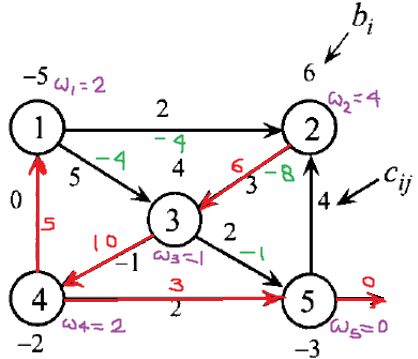

In [6]:
x_full = np.zeros_like(c)
x_full[basic_var] = x_sol
z = np.dot(c, x_full)
print("z* =", z)

z* = 14


#### 2. Modele el problema 1 como un problema de programación lineal

##### a) Ponerlo en la forma estandar y resolverlo utilizando el método simplex (Use Big M o dos fases para hallar una primera solución básica factible).(3 ptos)


In [7]:
A_np = np.array([[1, 1, 0, 0, 0, -1, 0, 0, 0., 1, 0, 0, 0, 0],
                 [0, -1, 1, 0, 0, 0, 0, -1, 0, 0, 1, 0, 0, 0],
                 [-1, 0, -1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
                 [0, 0, 0, -1, 0, 1, 1, 0, 0., 0, 0, 0, 1, 0],
                 [0, 0, 0, 0, -1, 0, -1, 1, 1, 0, 0, 0, 0, 1]])

c_max = -np.array([5, 2, 3, -1, 2, 0, 2, 4, 0.])

c_artificial = [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1.0, -1]

basic_index = [9, 10, 11, 12, 13]
artificial_index = [9, 10, 11, 12, 13]

tableau = build_tableau(A_np, b, c_artificial)
tableau = two_phases(tableau, c_max, basic_index, artificial_index)


x_B = [10, 11, 12, 13, 14]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1. -1.  0.]
 [ 1.  1.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0. -5.]
 [ 0. -1.  1.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  6.]
 [-1.  0. -1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  4.]
 [ 0.  0.  0. -1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0. -2.]
 [ 0.  0.  0.  0. -1.  0. -1.  1.  1.  0.  0.  0.  0.  1. -3.]]
Cost corrected
x_B = [10, 11, 12, 13, 14]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0. -5.]
 [ 0. -1.  1.  0.  0.  0.  0. -1.  0.  0.  1.  0.  0.  0.  6.]
 [-1.  0. -1.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  4.]
 [ 0.  0.  0. -1.  0.  1.  1.  0.  0.  0.  0.  0.  1.  0. -2.]
 [ 0.  0.  0.  0. -1.  0. -1.  1.  1.  0.  0.  0.  0.  1. -3.]]
Start phase One
x_B = [10, 11, 12, 13, 9]
[[ 0.  0.  0.  0.  1.  0.  1. -1.  0.  0.  0.  0.  0. -1.  3.]
 [ 1.  1.  0.  0.  0. -1.  0.  0.  0.  1.  0.  0.  0.  0. -5.]
 [ 0.

##### b) Halle el modelo dual del problema de programación lineal.(3 ptos)


In [8]:
A_T = A.T
print_model(A_T, c, b, "y", list(range(1, A_T.shape[1] + 1)), ["\le"] * A_T.shape[0], "max")
# obs yi es free!!!


##### c) ¿Qué pasa con la función objetivo si cada bi es perturbado por un $δ$?. Halle los intervalos de tolerancia para cada caso.(3 ptos)


##### d) ¿Qué pasa con la función objetivo si cada $c_{ij}$ es perturbado por un $δ$?. Halle los intervalos de tolerancia para cada caso.(3 ptos)

# Práctica Calificada 6

#### 2. Dado el problema de flujo de costo mínimo, determinar el problema lineal asociado e implemente un algoritmo que resuelva el problema

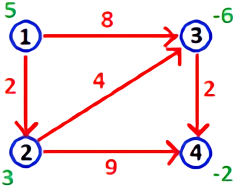

In [9]:
number_nodes = 4
edges: list[Edge] = [Edge(1, 2, 2),
                     Edge(1, 3, 8),
                     Edge(2, 3, 4),
                     Edge(2, 4, 9),
                     Edge(3, 4, 2),
                     Edge(4, np.Inf, 0)]

A = build_matrix(number_nodes, edges)
b = np.array([5, 3, -6, -2])  # sum(b) = 0
c = -np.array(list(map(lambda e: e.cost, edges)))
var = set(range(len(edges)))


Modelo

In [10]:
print_model(A, b, c, "x", get_edges(edges, list(var)), ["="] * number_nodes, "max")


Solución utilizando el método simplex

In [11]:
tableau = build_tableau(A, b, c).astype(float)
basic_index = [0, 2, 3, 5]
print(tableau)
correct_all_tableau(tableau, basic_index)
simplex(tableau, basic_index);


[[-2. -8. -4. -9. -2.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  5.]
 [-1.  0.  1.  1.  0.  0.  3.]
 [ 0. -1. -1.  0.  1.  0. -6.]
 [ 0.  0.  0. -1. -1.  1. -2.]]
All tableau corrected
vertex = [5. 0. 6. 2. 0. 0.], x_B = [1, 3, 4, 6]
[[ 0. -2.  0.  0.  3.  0. 52.]
 [ 1.  1.  0.  0.  0.  0.  5.]
 [ 0.  1.  1.  0. -1.  0.  6.]
 [ 0.  0.  0.  1.  1.  0.  2.]
 [ 0.  0.  0.  0.  0.  1.  0.]]
vertex = [5. 0. 8. 0. 2. 0.], x_B = [1, 3, 5, 6]
[[ 0. -2.  0. -3.  0.  0. 46.]
 [ 1.  1.  0.  0.  0.  0.  5.]
 [ 0.  1.  1.  1.  0.  0.  8.]
 [ 0.  0.  0.  1.  1.  0.  2.]
 [ 0.  0.  0.  0.  0.  1.  0.]]


Solución utilizando two-phases (obs: agregar la arista infinita)

In [12]:
A = np.array([[1, 1., 0., 0., 0., 0, 1, 0, 0, 0],
              [-1, 0, 1., 1., 0., 0, 0, 1, 0, 0],
              [0, -1, -1, 0., 1., 0, 0, 0, 1, 0],
              [0, 0., 0., -1, -1, 1, 0, 0, 0, 1]])

c = np.array([-2, -8, -4, -9, -2, 0])

c_artificial = [0, 0, 0, 0, 0, 0, -1, -1, -1, -1.0]

basic_index = [6, 7, 8, 9]
artificial_index = [6, 7, 8, 9]

tableau = build_tableau(A, b, c_artificial)
tableau = two_phases(tableau, c, basic_index, artificial_index)


x_B = [7, 8, 9, 10]
[[ 0.  0.  0.  0.  0.  0. -1. -1. -1. -1.  0.]
 [ 1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  5.]
 [-1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  3.]
 [ 0. -1. -1.  0.  1.  0.  0.  0.  1.  0. -6.]
 [ 0.  0.  0. -1. -1.  1.  0.  0.  0.  1. -2.]]
Cost corrected
x_B = [7, 8, 9, 10]
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  5.]
 [-1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  3.]
 [ 0. -1. -1.  0.  1.  0.  0.  0.  1.  0. -6.]
 [ 0.  0.  0. -1. -1.  1.  0.  0.  0.  1. -2.]]
Start phase One
x_B = [7, 8, 9, 6]
[[ 0.  0.  0.  1.  1.  0.  0.  0.  0. -1.  2.]
 [ 1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  5.]
 [-1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  3.]
 [ 0. -1. -1.  0.  1.  0.  0.  0.  1.  0. -6.]
 [ 0.  0.  0. -1. -1.  1.  0.  0.  0.  1. -2.]]
x_B = [7, 4, 9, 6]
[[ 1.  0. -1.  0.  1.  0.  0. -1.  0. -1. -1.]
 [ 1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  5.]
 [-1.  0.  1.  1.  0.  0.  0.  1.  0.  0.  3.]
 [ 0. -1. -1.  0.  1.  0.  0.  0.  1.  0. 

Utilizando grafos

In [13]:
# costo positivo
c = np.array(list(map(lambda e: e.cost, edges)))


In [14]:
A = np.array(A).astype(float)
basic_var = [0, 2, 3, 5]
basic_edges = get_edges(edges, basic_var)
print(f"variables básicas\nBI = {basic_var}")
print_vector("map", "a", [r"x_{%s}" % i for i in basic_var], basic_edges)

B = A[:, basic_var]
print(f"Matriz B\n{B}")
x_sol = np.linalg.inv(B) @ b
print_vector("solución básica (flujos)", "a", x_sol, basic_edges)

# solución dual
w = np.linalg.inv(B).T @ c[basic_var]
# en el dibujo de flujo en redes, situo la wi en la cola del enlace aij
print_vector("variable dual", "w", w)

non_basic_var = list(var - set(basic_var))
non_basic_edges = get_edges(edges, non_basic_var)
# aún no es negativo, lo cambiamos
z = w @ A[:, non_basic_var] - c[non_basic_var]
print_vector("costos no básicos", "w", z, non_basic_edges)



variables básicas
BI = [0, 2, 3, 5]


Matriz B
[[ 1.  0.  0.  0.]
 [-1.  1.  1.  0.]
 [ 0. -1.  0.  0.]
 [ 0.  0. -1.  1.]]


In [15]:
basic_var = [0, 2, 4, 5]
basic_edges = get_edges(edges, basic_var)
print(f"variables básicas\nBI = {basic_var}")
print_vector("map", "a", [r"x_{%s}" % i for i in basic_var], basic_edges)

B = A[:, basic_var]
print(f"Matriz B\n{B}")
x_sol = np.linalg.inv(B) @ b
print_vector("solución básica (flujos)", "a", x_sol, basic_edges)

# solución dual
w = np.linalg.inv(B).T @ c[basic_var]
# en el dibujo de flujo en redes, situo la wi en la cola del enlace aij
print_vector("variable dual", "w", w, list(range(1, len(w) + 1)))

non_basic_var = list(var - set(basic_var))
non_basic_edges = get_edges(edges, non_basic_var)
# aún no es negativo, lo cambiamos
z = w @ A[:, non_basic_var] - c[non_basic_var]
print_vector("costos no básicos", "w", z, non_basic_edges)


variables básicas
BI = [0, 2, 4, 5]


Matriz B
[[ 1.  0.  0.  0.]
 [-1.  1.  0.  0.]
 [ 0. -1.  1.  0.]
 [ 0.  0. -1.  1.]]


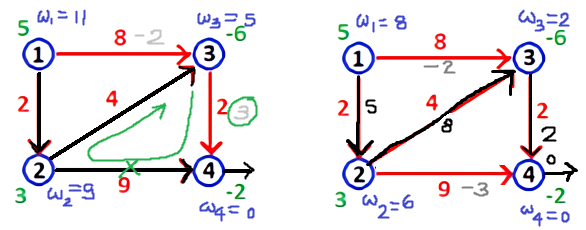

In [16]:
x_full = np.zeros_like(c)
x_full[basic_var] = x_sol
z = np.dot(c, x_full)
print("z* =", z)

z* = 46
